### Analyse results

This notebook provides basic functionality to analyse the produced files and resulting optimization problems from the conversion_energyscope workflow.

The scenario name and country of interest can be adapted in the first code box.


In [1]:
from amplpy import AMPL
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths and parameters
ce_root = Path.cwd()
Country="CH" # Choose country ISO code 
scenario_name = "Europe_2019_39_2050"

# Initialize and solve AMPL model
ampl = AMPL()
ampl.read(str(ce_root / "core_files" / "ESTD_model_core.mod"))
ampl.readData(str(ce_root / "output" / f"{scenario_name}" / "dat_files" / f"ESTD_{Country}_12TD.dat"))
ampl.readData(str(ce_root / "output" / f"{scenario_name}" / "dat_files" / f"ESTD_{Country}_data_core.dat"))
ampl.setOption("solver", "gurobi")
ampl.solve()

Gurobi 12.0.3Gurobi 12.0.3: optimal solution; objective 24833.70074
35629 simplex iterations
82 barrier iterations
Gurobi 12.0.3: optimal solution; objective 24833.70074
35629 simplex iterations
82 barrier iterations


### Total System Cost

In [2]:
# Get results (example: TotalCost)
TotalCost = ampl.getVariable("TotalCost")
print("Total cost:", TotalCost.get().value())
TotalGWP = ampl.getVariable("TotalGWP")
print("Total GWP emissions:", TotalGWP.get().value())


Total cost: 24833.70074470653
Total GWP emissions: 0.0


### Onshore Wind - Capacity Factors

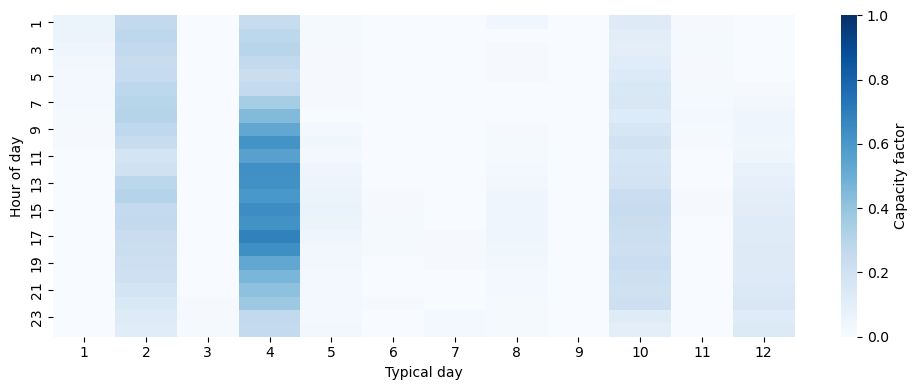

In [3]:
# Extract scenario year
scenario_year = int(scenario_name.split("_")[1])

# Extract and process results for visualization
thtd = (
    ampl.getSet("T_H_TD")
    .get_values()
    .to_pandas()
    .reset_index()
    .rename(columns={"index0": "period", "index1": "hour", "index2": "typical_day"})
)

cpt_raw = (
    ampl.getParameter("c_p_t")
    .get_values()
    .to_pandas()
    .reset_index()
)

cpt = cpt_raw.rename(columns={
    "index0": "technology",
    "index1": "hour",
    "index2": "typical_day",
})
cpt = cpt.rename(columns={cpt.columns[-1]: "capacity_factor"})

# Plot heatmap of WIND_ONSHORE capacity factors
heat_df = (
    cpt.loc[cpt["technology"] == "WIND_ONSHORE", ["typical_day", "hour", "capacity_factor"]]
    .sort_values(["hour", "typical_day"])
    .pivot(index="hour", columns="typical_day", values="capacity_factor")
)

plt.figure(figsize=(10, 4))
sns.heatmap(
    heat_df,
    cmap="Blues",
    vmin=0,
    vmax=1,
    cbar_kws={"label": "Capacity factor"},
)
#plt.title(f"WIND_ONSHORE capacity factors – hours vs. typical days ({Country})")
plt.xlabel("Typical day")
plt.ylabel("Hour of day")
plt.tight_layout()

### Offshore Wind - Capacity Factors

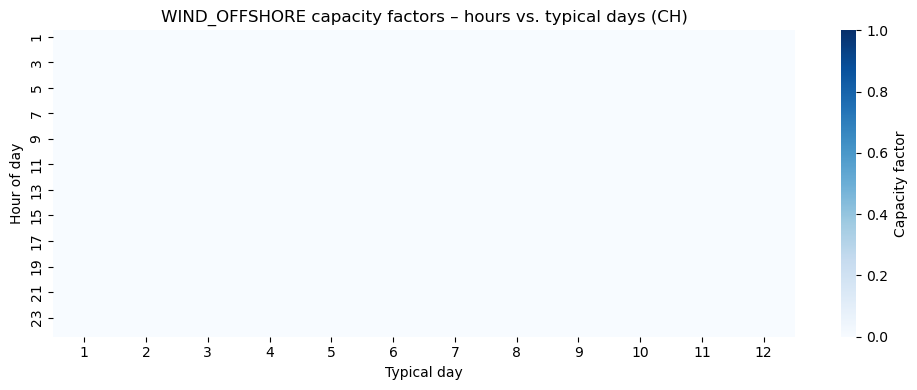

In [4]:
# Plot heatmap of WIND_OFFSHORE capacity factors
offwind_heat = (
    cpt.loc[cpt["technology"] == "WIND_OFFSHORE", ["typical_day", "hour", "capacity_factor"]]
    .sort_values(["hour", "typical_day"])
    .pivot(index="hour", columns="typical_day", values="capacity_factor")
)

plt.figure(figsize=(10, 4))
sns.heatmap(
    offwind_heat,
    cmap="Blues",
    vmin=0,
    vmax=1,
    cbar_kws={"label": "Capacity factor"},
)
plt.title(f"WIND_OFFSHORE capacity factors – hours vs. typical days ({Country})")
plt.xlabel("Typical day")
plt.ylabel("Hour of day")
plt.tight_layout()

### PV - Capacity Factors

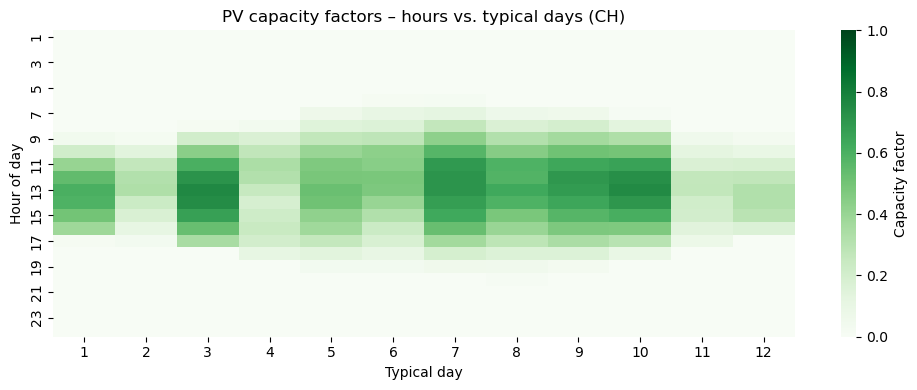

In [5]:
# Plot heatmap of PV capacity factors
solar_heat = (
    cpt.loc[cpt["technology"] == "PV", ["typical_day", "hour", "capacity_factor"]]
    .sort_values(["hour", "typical_day"])
    .pivot(index="hour", columns="typical_day", values="capacity_factor")
)

plt.figure(figsize=(10, 4))
sns.heatmap(
    solar_heat,
    cmap="Greens",
    vmin=0,
    vmax=1,
    cbar_kws={"label": "Capacity factor"},
)
plt.title(f"PV capacity factors – hours vs. typical days ({Country})")
plt.xlabel("Typical day")
plt.ylabel("Hour of day")
plt.tight_layout()



### Run-of-River - Capacity Factors

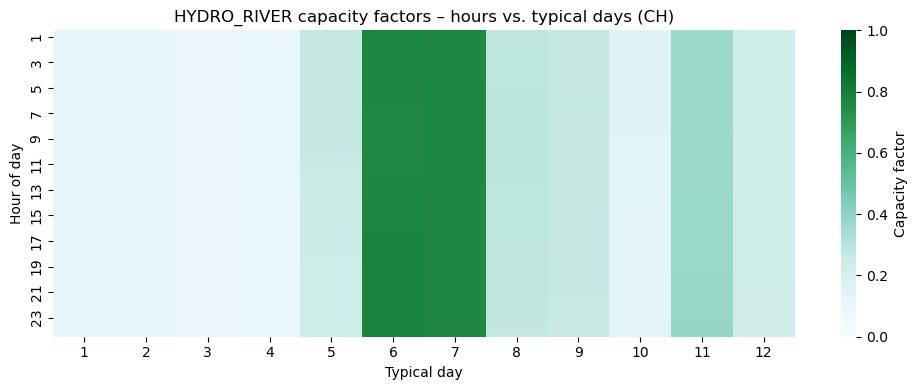

In [6]:
# Plot heatmap of HYDRO_RIVER capacity factors
ror_heat = (
    cpt.loc[cpt["technology"] == "HYDRO_RIVER", ["typical_day", "hour", "capacity_factor"]]
    .sort_values(["hour", "typical_day"])
    .pivot(index="hour", columns="typical_day", values="capacity_factor")
)

plt.figure(figsize=(10, 4))
sns.heatmap(
    ror_heat,
    cmap="BuGn",
    vmin=0,
    vmax=1,
    cbar_kws={"label": "Capacity factor"},
)
plt.title(f"HYDRO_RIVER capacity factors – hours vs. typical days ({Country})")
plt.xlabel("Typical day")
plt.ylabel("Hour of day")
plt.tight_layout()


### Full Load Hours

In [7]:
# Expand typical day data to full 8760-hour time series
def expand_cf(tech):
    cf = (
        thtd.merge(
            cpt.loc[cpt["technology"] == tech, ["hour", "typical_day", "capacity_factor"]],
            on=["hour", "typical_day"],
            how="left",
        )
        .sort_values("period")
    )
    cf["timestamp"] = (
        pd.Timestamp(f"{scenario_year}-01-01")
        + pd.to_timedelta(cf["period"] - 1, unit="h")
    )
    return cf.set_index("timestamp")

onwind_cf = expand_cf("WIND_ONSHORE")
offwind_cf = expand_cf("WIND_OFFSHORE")  
pv_cf = expand_cf("PV")
ror_cf = expand_cf("HYDRO_RIVER")


# Full-load hours based on the expanded 8760-hour series
onshore_flh = onwind_cf["capacity_factor"].sum()
offshore_flh = offwind_cf["capacity_factor"].sum()
pv_flh = pv_cf["capacity_factor"].sum()
ror_flh = ror_cf["capacity_factor"].sum()

print(f"Onshore wind full-load hours ({Country}): {onshore_flh:.0f} h/year")
print(f"Offshore wind full-load hours ({Country}): {offshore_flh:.0f} h/year")
print(f"PV full-load hours ({Country}): {pv_flh:.0f} h/year")
print(f"Run-of-river hydro full-load hours ({Country}): {ror_flh:.0f} h/year")

Onshore wind full-load hours (CH): 463 h/year
Offshore wind full-load hours (CH): 0 h/year
PV full-load hours (CH): 1378 h/year
Run-of-river hydro full-load hours (CH): 2382 h/year


### Installed Capacities

In [8]:
capacity = (
    ampl.getVariable("F")
        .get_values()
        .to_pandas()
        .reset_index()
        .rename(columns={"index": "technology", "F.val": "capacity_GW"})
        .sort_values("capacity_GW", ascending=False)
)

display(capacity)

,technology,capacity_GW
104,TS_DHN_SEASONAL,4166.341815
55,GAS_STORAGE,2531.910199
15,CAR_BEV,113.597931
3,BATT_LI,63.435243
79,PV,56.492651
...,...,...
37,DEC_SOLAR,0.000000
35,DEC_DIRECT_ELEC,0.000000
34,DEC_COGEN_OIL,0.000000
33,DEC_COGEN_GAS,0.000000


### Resources

In [9]:
# fetch full F_t table and rename columns
F_t = (
    ampl.getVariable("F_t")
    .get_values()
    .to_pandas()
    .reset_index()
    .rename(columns={"index0": "item", "index1": "hour", "index2": "typical_day"})
)
F_t = F_t.rename(columns={F_t.columns[-1]: "flow"})
F_t["item"] = F_t["item"].astype(str).str.strip().str.replace("'", "", regex=False)

# flatten RESOURCES set into plain strings
resource_items = [str(v).strip().strip("'") for v in ampl.getSet("RESOURCES")]

# filter and aggregate
resource_totals_df = (
    F_t[F_t["item"].isin(resource_items)]
    .groupby("item", as_index=False)["flow"]
    .sum()
    .sort_values("flow", ascending=False)
)

print(resource_totals_df)


             item         flow
22      RES_SOLAR  2529.306180
1      AMMONIA_RE   696.796016
27           WOOD   414.216059
21      RES_HYDRO   353.692397
23       RES_WIND   228.938216
25          WASTE   220.613828
6   CO2_EMISSIONS   182.358019
11    ELEC_EXPORT   171.036773
26    WET_BIOMASS     0.562464
16          H2_RE     0.000000
24        URANIUM     0.000000
20        RES_GEO     0.000000
19    METHANOL_RE     0.000000
18       METHANOL     0.000000
17            LFO     0.000000
0         AMMONIA     0.000000
15             H2     0.000000
13       GASOLINE     0.000000
12            GAS     0.000000
10    ELECTRICITY     0.000000
9          DIESEL     0.000000
8            COAL     0.000000
7    CO2_INDUSTRY     0.000000
5    CO2_CAPTURED     0.000000
4         CO2_ATM     0.000000
3      BIOETHANOL     0.000000
2       BIODIESEL     0.000000
14         GAS_RE     0.000000


### Heating Demand

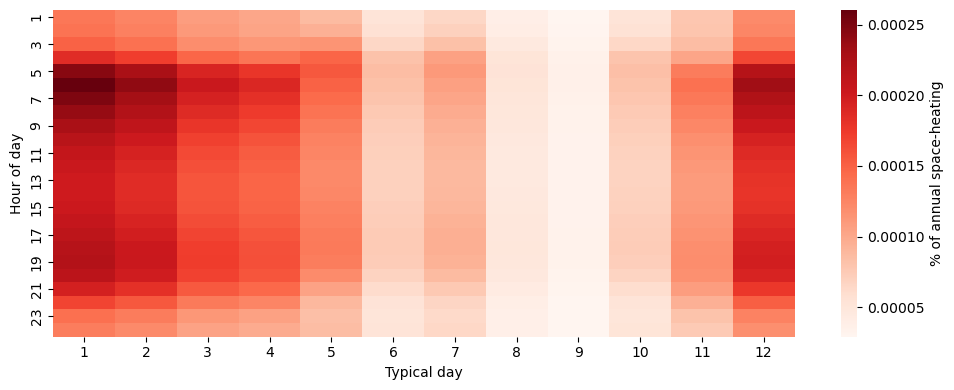

In [10]:
# Plot heatmap of heating demand time series
heat_param = ampl.getParameter("heating_time_series")
raw = heat_param.getValues().toPandas()

# Reset index to convert multi-index to columns
heat_df = raw.reset_index()
heat_df.columns = ['hour', 'typical_day', 'value']

# Pivot to create heatmap
heat_df = heat_df.pivot(index='hour', columns='typical_day', values='value').sort_index()
heat_df.index = heat_df.index.astype(int)
heat_df.columns = heat_df.columns.astype(int)

plt.figure(figsize=(10, 4))
sns.heatmap(
    heat_df,
    cmap="Reds",
    cbar_kws={"label": "% of annual space-heating"},
)
plt.xlabel("Typical day")
plt.ylabel("Hour of day")
#plt.title(f"Heating demand – {Country} – {heat_df.shape[1]} TDs")
plt.tight_layout()

### Electricty Demand

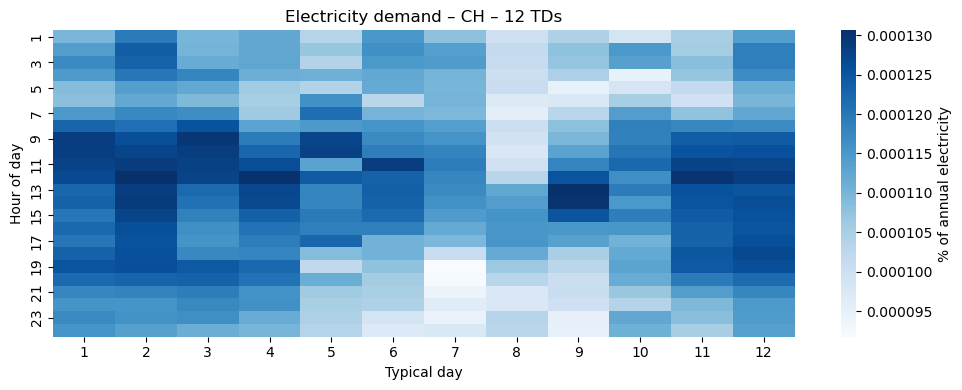

In [11]:
# Plot heatmap of electricity demand time series
elec_param = ampl.getParameter("electricity_time_series")
raw_elec = elec_param.getValues().toPandas()

# Reset index to convert multi-index to columns
elec_df = raw_elec.reset_index()
elec_df.columns = ['hour', 'typical_day', 'value']

# Pivot to create heatmap
elec_df = elec_df.pivot(index='hour', columns='typical_day', values='value').sort_index()
elec_df.index = elec_df.index.astype(int)
elec_df.columns = elec_df.columns.astype(int)

plt.figure(figsize=(10, 4))
sns.heatmap(
    elec_df,
    cmap="Blues",
    cbar_kws={"label": "% of annual electricity"},
)
plt.xlabel("Typical day")
plt.ylabel("Hour of day")
plt.title(f"Electricity demand – {Country} – {elec_df.shape[1]} TDs")
plt.tight_layout()